Hypotesis: egtm = egt redline - egt

Idea: egt redline may depend on engine hours linearly. I want to plot (egt - etgm) vs engine hours 

23.11.2023: After trying to guess formula with PySR still no luck.

##### Ideas: 

1. More carefully select important features. Try linear regression + PCA for this instead of catboost.important_features
2. Leave no more than 8 features, probably 4-5
3. Drop records containing NaN's completely
4. Try different pysr settings according to manual

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 

dataset = pd.read_csv('./small-sample-BGU-30.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

In [4]:
important_features = [
 'egt', 'naiup', 'nait', 'tec', 'aoc', 'ecyc', 'esn', 'ehrs', 'fdp', 'ps14', 'w14', 'egtb'
]

In [5]:
Y = dataset[['egtm']]

X = dataset.drop(columns=[
    'reportts', 'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(0)

X = X.loc[:, ~X.columns.str.contains('stw')]

### PCA variance

In [6]:
def get_pca(X, y, n_components=5):
  y = Y['egtm']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

  scaler = StandardScaler()
  scaler.fit(X_train)

  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  pca = PCA(n_components=n_components)
  pca.fit(X_train)

  X_train = pca.transform(X_train)
  X_test = pca.transform(X_test)

  model = LinearRegression(n_jobs=-1)
  model.fit(X_train, y_train)

  predicted = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted, squared=False)

  return mse, model, pca

As seen from PCA variance plot, this dataset has big variance and cannot be reduced to several dimensions

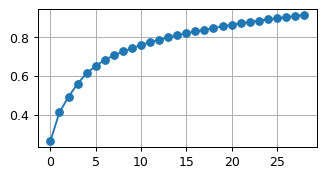

In [7]:
pca_result = []

for n in range(1, 30):
    rmse, model, pca = get_pca(X, Y, n_components=n)
    pca_result.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(4,2), dpi=90)
plt.grid()
plt.plot(pca_result, marker='o')
plt.show()

### Feature importance from Decision tree

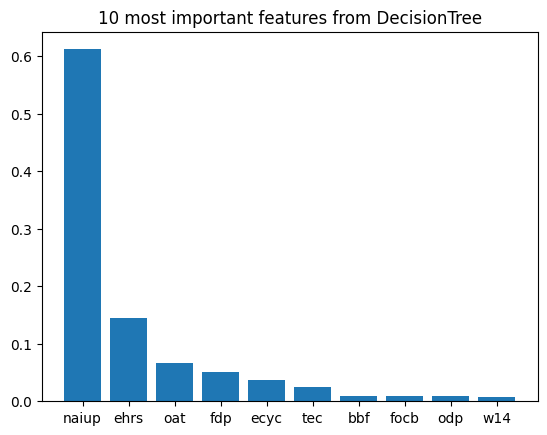

In [8]:
def get_feature_importance(X, y):
    model = DecisionTreeRegressor()
    model.fit(X, y)
    return pd.DataFrame({
        'importance': model.feature_importances_, 
        'feature': X.columns
    }).sort_values('importance', ascending=False)

imp = get_feature_importance(X, Y['egtm'])[:10]
plt.bar(imp['feature'], imp['importance'])
plt.title('10 most important features from DecisionTree')
plt.show()


In [9]:
important_features = ['naiup', 'ecyc', 'oat', 'fdp', 'ehrs', 'tec', 't2']

### Naive feature generation for linreg

In [10]:
def train_model(X, y):
  y = Y['egtm']
  x = X[y.notna()]
  y = y.dropna()

  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=40)

  scaler = StandardScaler()
  scaler.fit(X_train)

  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  model = LinearRegression(n_jobs=-1)
  model.fit(X_train, y_train)

  predicted = model.predict(X_test)
  preds = pd.DataFrame({'y': y_test, 'pred': predicted})
  mse = mean_squared_error(y_test, predicted, squared=False)
  mae = mean_absolute_error(y_test, predicted)
  
  return mse, mae, model, preds

In [11]:
mse, mae, result_model, pred = train_model(X, Y)
mse

3.076183887153774

In [12]:
mse, mae, result_model, pred = train_model(X[important_features], Y)
mse

2.972254842820737

Let's add multiplication and square features

In [13]:
X_aug = X[important_features].copy()
for f in important_features:
  X_aug[f + '_2'] = X_aug[f] ** 2
  for k in important_features:
    if f != k:
      X_aug[f + '_m_' + k] = X_aug[f] * X_aug[k]

In [14]:
X_aug.head(3)

,naiup,ecyc,oat,fdp,ehrs,tec,t2,naiup_2,naiup_m_ecyc,naiup_m_oat,...,tec_m_fdp,tec_m_ehrs,tec_m_t2,t2_2,t2_m_naiup,t2_m_ecyc,t2_m_oat,t2_m_fdp,t2_m_ehrs,t2_m_tec
0,128.8,0,1.6,11.3,0,13.0,3.0,16589.44,0.0,206.08,...,146.9,0.0,39.0,9.00,386.40,0.0,4.80,33.90,0.0,39.0
510,127.6,0,1.6,10.4,0,10.0,3.1,16281.76,0.0,204.16,...,104.0,0.0,31.0,9.61,395.56,0.0,4.96,32.24,0.0,31.0
1,129.0,2,9.0,12.0,4,24.0,10.4,16641.00,258.0,1161.00,...,288.0,96.0,249.6,108.16,1341.60,20.8,93.60,124.80,41.6,249.6


In [15]:
mse, mae, result_model, pred = train_model(X_aug, Y)
mse

2.177803939457297

In [16]:
X_aug.head(4)

,naiup,ecyc,oat,fdp,ehrs,tec,t2,naiup_2,naiup_m_ecyc,naiup_m_oat,...,tec_m_fdp,tec_m_ehrs,tec_m_t2,t2_2,t2_m_naiup,t2_m_ecyc,t2_m_oat,t2_m_fdp,t2_m_ehrs,t2_m_tec
0,128.8,0,1.6,11.3,0,13.0,3.0,16589.44,0.0,206.08,...,146.9,0.0,39.0,9.00,386.40,0.0,4.80,33.90,0.0,39.0
510,127.6,0,1.6,10.4,0,10.0,3.1,16281.76,0.0,204.16,...,104.0,0.0,31.0,9.61,395.56,0.0,4.96,32.24,0.0,31.0
1,129.0,2,9.0,12.0,4,24.0,10.4,16641.00,258.0,1161.00,...,288.0,96.0,249.6,108.16,1341.60,20.8,93.60,124.80,41.6,249.6
511,128.3,2,9.0,10.8,4,23.0,10.6,16460.89,256.6,1154.70,...,248.4,92.0,243.8,112.36,1359.98,21.2,95.40,114.48,42.4,243.8


### Equation discovery with PySR

In [17]:
# !pip3 install -U pysr -q
# !python3 -m pysr install

We got 6 important features from Decision Tree `(['naiup', 'ecyc', 'oat', 'fdp', 'ehrs', 'tec'])`, let's try to find a formula for EGTM

In [18]:
X[important_features].isna().sum()

naiup    0
ecyc     0
oat      0
fdp      0
ehrs     0
tec      0
t2       0
dtype: int64

In [19]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=1_000, 
    maxdepth=10,
    binary_operators=["*", "+", "-", "/"],
    early_stop_condition=(
        "stop_if(loss, complexity) = loss < 1e-2"
    ),
    unary_operators=[
        "square",
        "inv(x) = 1/x",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # loss="loss(prediction, target) = (prediction - target)^2",
)

y = Y['egtm']
x = X[important_features]

model.fit(x, y)

/home/b.korzh@group.s7/miniconda3/envs/recsys/lib/python3.9/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/home/b.korzh@group.s7/miniconda3/envs/recsys/lib/python3.9/site-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(


Started!

Expressions evaluated per second: 2.490e+05
Head worker occupation: 17.1%
Progress: 531 / 15000 total iterations (3.540%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.474e+01  1.594e+01  y = 28.662
3           1.814e+01  4.513e-01  y = (naiup + -95.039)
5           1.663e+01  4.343e-02  y = ((-82.395 - fdp) + naiup)
7           1.507e+01  4.929e-02  y = (((-0.0066001 * ecyc) - 92.807) + naiup)
9           1.484e+01  7.751e-03  y = (((-82.395 - (oat / fdp)) - fdp) + naiup)
10          1.311e+01  1.240e-01  y = (((-80.025 - (square(-0.083711) * ecyc)) - fdp) + naiup)
12          1.301e+01  3.802e-03  y = (((-80.025 - (square(-0.083711) * (ecyc + oat))) - fdp) + ...
                                  naiup)
14          1.293e+01  2.853e-03  y = (((-80.025 - (square(-0.083711) * (ecyc + (oat + oat)))) -...
                                   fdp) + naiup)
16 

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          28.662113   
	1         0.451307                                (naiup + -95.03932)   
	2         0.043434                        ((-82.39478 - fdp) + naiup)   
	3         0.049295       (((-0.006598828 * ecyc) - 92.80725) + naiup)   
	4   >>>>  0.069759  (((-80.0037 - (0.0070704957 * ecyc)) - fdp) + ...   
	5         0.014407  ((((-67.19991 + naiup) - fdp) - (0.0075412793 ...   
	6         0.001344  ((((-67.19991 + naiup) - fdp) - (0.0075412793 ...   
	7         0.016698  ((((-67.19991 + naiup) - fdp) - (square(-0.008...   
	8         0.001179  ((((-67.19991 + naiup) - fdp) - (square(-0.008...   
	9         0.007700  ((((-79.21917 - (0.044667628 * (ecyc + tec))) ...   
	10        0.005963  ((((-79.09745 - (0.017232226 * ecyc)) - fdp) +...   
	11        0.000030  ((((-79.09745 - (0.017232226 * ecyc)) - fdp) +...   
	12        0.025334  ((((-67.19991 + naiup) - fdp) - (square(square...   
	
	         loss  complexity  
	0   44.737130           1  
	1   18.141293           3  
	2   16.631903           5  
	3   15.070414           7  
	4   13.107904           9  
	5   12.735597          11  
	6   12.701404          13  
	7   12.491071          14  
	8   12.461644          16  
	9   12.366053          17  
	10  12.292536          18  
	11  12.292166          19  
	12  11.984670          20  
]

In [20]:
model.predict(x)

array([37.4963    , 37.1963    , 36.98215901, ..., 18.13977789,
       23.5236317 , 16.4236317 ])

In [21]:
test = pd.DataFrame({
    'x1': np.random.random(10) * 2,
    'x2': np.random.random(10) * 5,
})

test['y'] = -10.4 * (test['x1'] ** 2) + 35 * test['x1'] * test['x2'] - 45.5

In [22]:
# model2 = PySRRegressor(
#     niterations=100,
#     binary_operators=["*", "+", "-", "/"],
#     unary_operators=[
#         "square", "cube"
#         # "cos",
#         # "exp",
#         # "sin",
#         # "inv(x) = 1/x",
#     ],
#     # extra_sympy_mappings={"inv": lambda x: 1 / x},
#     loss="loss(prediction, target) = (prediction - target)^2",
# )

# model2.fit(test[['x1', 'x2']], test['y'])